In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

In [5]:
results = pd.read_csv("results_3.csv").drop(["Name", "State", "Created", "Runtime"], axis=1)

In [6]:
ptbxl_results = results.query("dataset == 'ptbxl'")
sleep_edf_results = results.query("dataset == 'sleep_edf'")
mimic_results = results.query("dataset == 'mimic'")

In [7]:
def compare_results(data, x="representation", y="test/fscore", hue="model"):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(data=data, x=x, y=y, hue=hue, ax=ax)
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

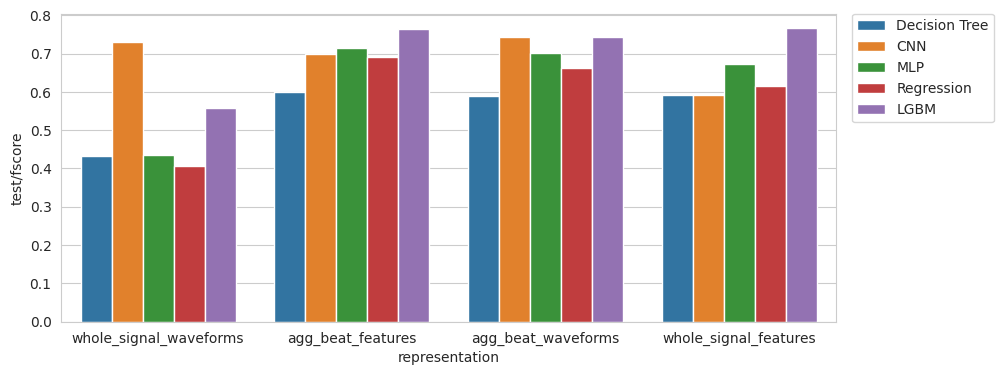

In [24]:
compare_results(
    data=ptbxl_results,
    x="representation",
    y="test/fscore",
    hue="model"
)

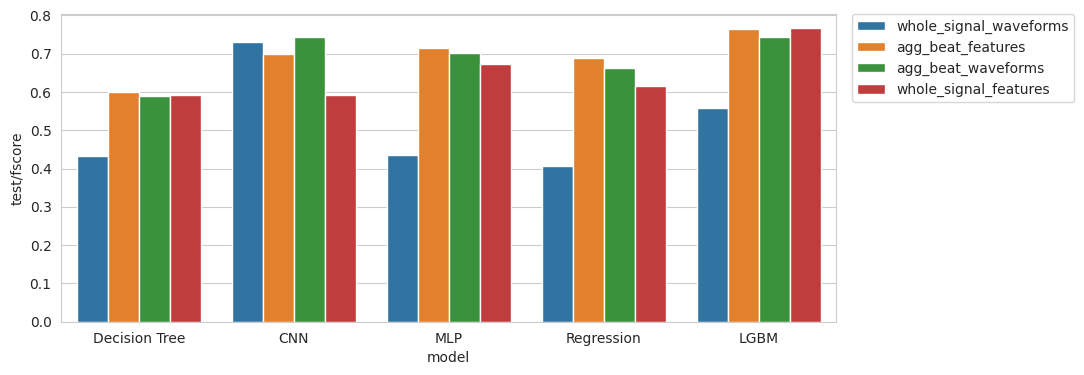

In [25]:
compare_results(
    data=ptbxl_results,
    x="model",
    y="test/fscore",
    hue="representation"
)

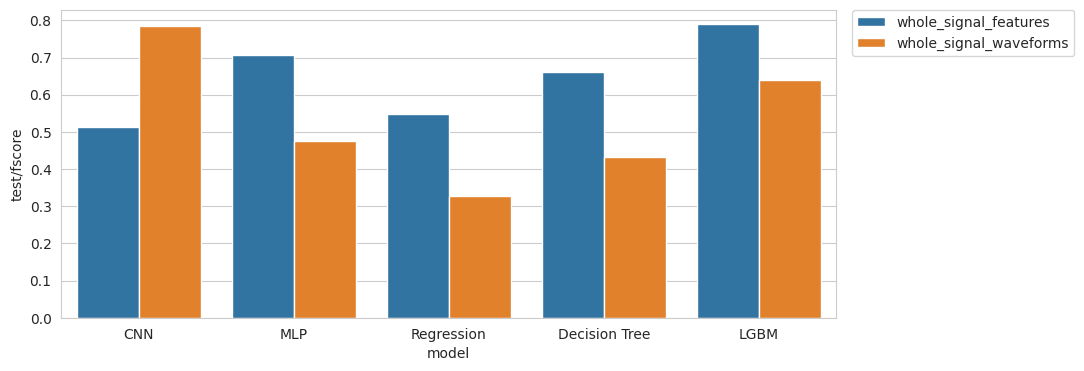

In [10]:
compare_results(
    data=sleep_edf_results,
    x="model",
    y="test/fscore",
    hue="representation"
)

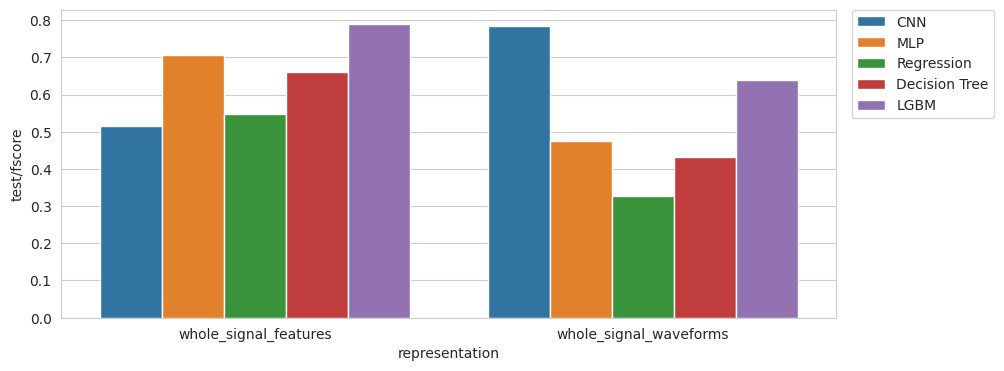

In [10]:
compare_results(
    data=sleep_edf_results,
    x="representation",
    y="test/fscore",
    hue="model"
)

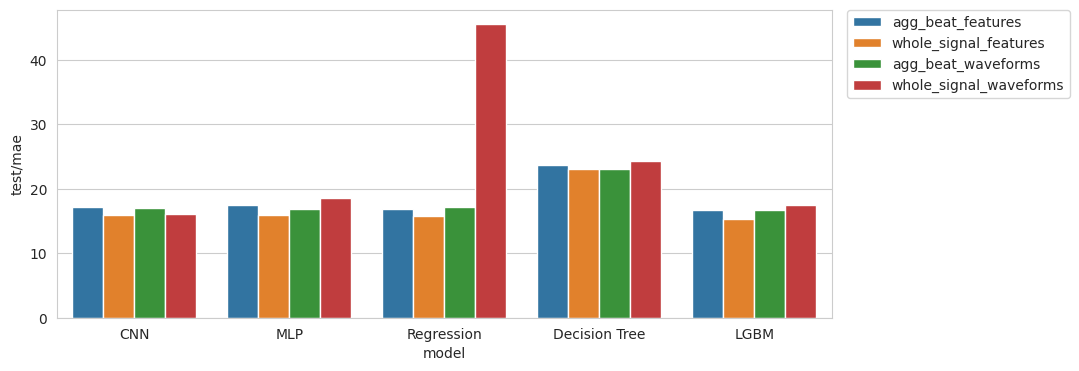

In [8]:
compare_results(
    data=mimic_results,
    x="model",
    y="test/mae",
    hue="representation"
)

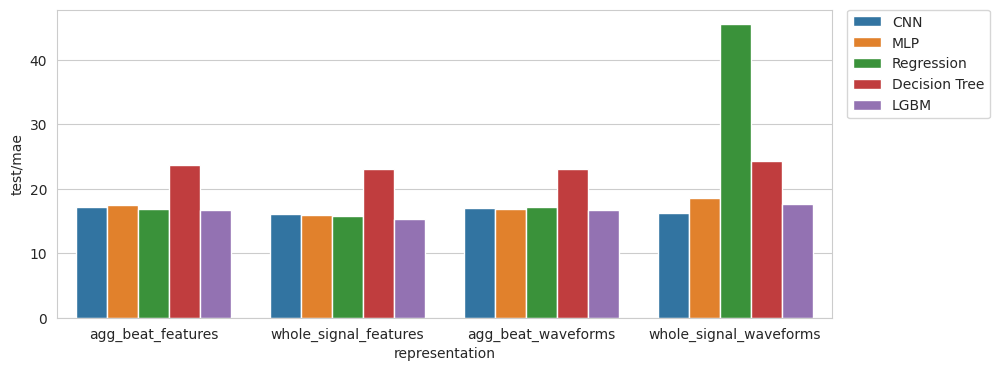

In [9]:
compare_results(
    data=mimic_results,
    x="representation",
    y="test/mae",
    hue="model"
)